In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [31]:
# DataSet generation
data_set = dict()

with open("stocks.txt", "r") as f:
    stocks = [line.strip() for line in f if line.strip()]

for stock in stocks:
    df = pd.read_csv(
        f"csv/{stock}_indicators.csv",
        index_col=0,       # use first column ("Date") as index
        parse_dates=[0],    # parse it as datetime
        date_format="ISO8601" #Specify date fromat
    ) 
    # ensure numeric and drop rows with NaNs in target/features
    df = df.apply(pd.to_numeric, errors='coerce')
    df["Target"] = df["Return"].shift(-1)
    
    df.dropna(subset=["Target"], inplace=True)
    if df.isnull().any().any():
        print(f"NaN detected in columns: {df.columns[df.isnull().any()].tolist()}")

    X = df.drop(columns=["Target"])
    Y = df["Target"]

    train_mask = X.index < "2025-01-01"
    test_mask = X.index >= "2025-01-01"
    X_train, X_test = X[train_mask], X[test_mask]
    Y_train, Y_test = Y[train_mask], Y[test_mask]
    
    if len(X_train) == 0 or len(X_test) == 0:
        print(f"Skipping storing {stock}: empty train/test split")
        continue

    
    data_set[stock] = {
        "X_train": X_train,
        "X_test": X_test,
        "Y_train": Y_train,
        "Y_test": Y_test
    }

    print("="*20 + stock + "="*20)
    print(f"Traing size {len(X_train)}")
    print(f"Test size {len(X_test)}\n")

====================AAPL====================
Traing size 2515
Test size 183

====================META====================
Traing size 2515
Test size 183

====================ORCL====================
Traing size 2515
Test size 183

====================MSFT====================
Traing size 2515
Test size 183




=== RandomForest for AAPL ===
Best params: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
RMSE: 0.0248 | MAE: 0.0151 | R2: -0.1695
Top feature importances:
 Return         0.310419
Volume         0.195594
MACD           0.141111
RSI            0.128850
Signal_Line    0.113613
STD20          0.110413


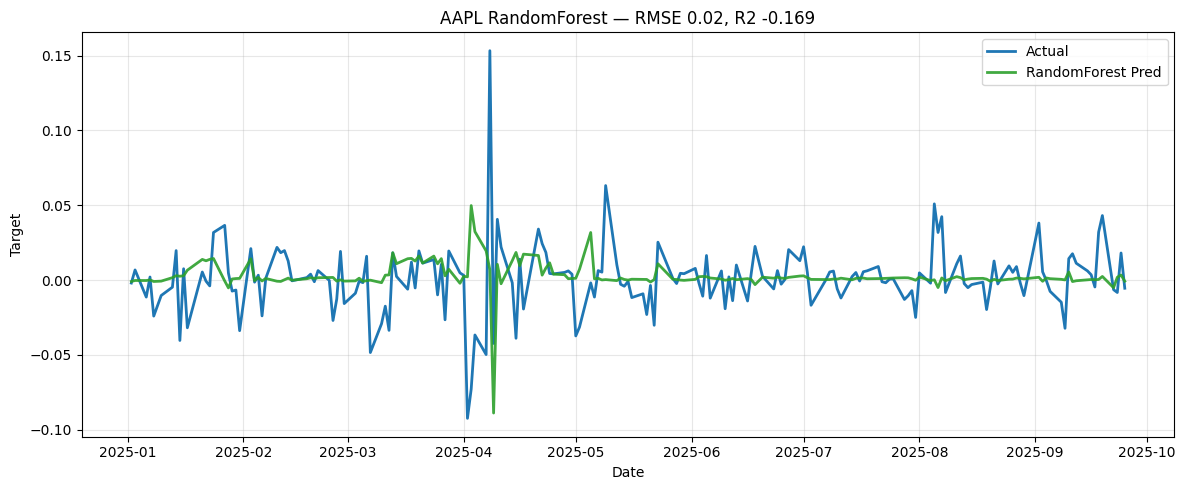


=== RandomForest for META ===
Best params: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
RMSE: 0.0256 | MAE: 0.0169 | R2: -0.0526
Top feature importances:
 Volume         0.350154
Return         0.167073
RSI            0.148189
Signal_Line    0.129812
MACD           0.115269
STD20          0.089503


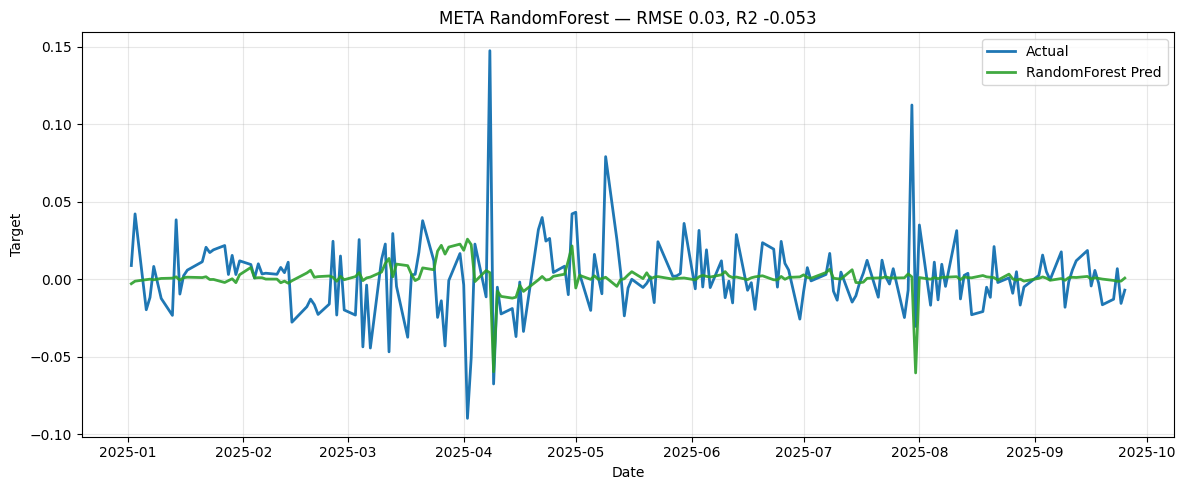


=== RandomForest for ORCL ===
Best params: {'rf__max_depth': 10, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}
RMSE: 0.0416 | MAE: 0.0242 | R2: -0.0280
Top feature importances:
 Return         0.337773
Volume         0.200897
MACD           0.137433
Signal_Line    0.118776
STD20          0.107205
RSI            0.097917


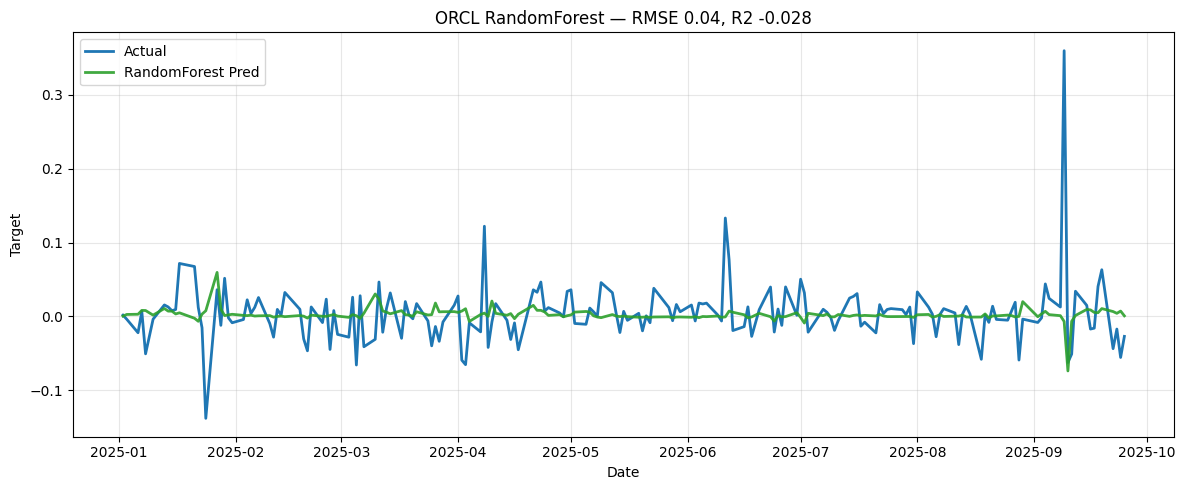


=== RandomForest for MSFT ===
Best params: {'rf__max_depth': 10, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
RMSE: 0.0164 | MAE: 0.0109 | R2: -0.0007
Top feature importances:
 Return         0.337672
Volume         0.197894
RSI            0.134226
MACD           0.124149
STD20          0.109546
Signal_Line    0.096513


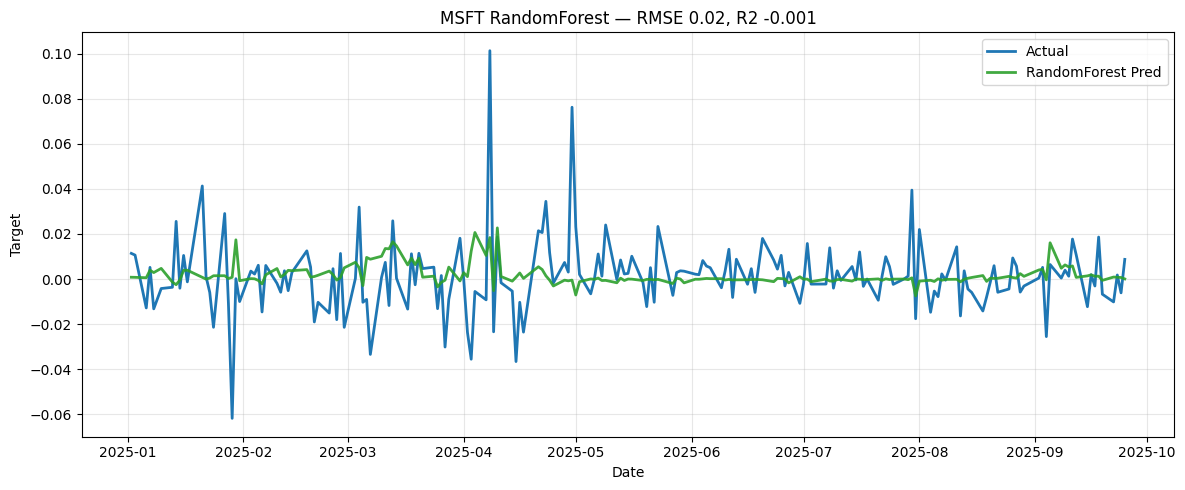


=== Summary ===
Stock     RMSE      MAE        R2                                                                     Params
 MSFT 0.016366 0.010903 -0.000748 {'rf__max_depth': 10, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
 AAPL 0.024784 0.015141 -0.169493 {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
 META 0.025588 0.016942 -0.052616 {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
 ORCL 0.041618 0.024197 -0.028020 {'rf__max_depth': 10, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}


In [32]:
results = []

for stock, data in data_set.items():

    X_train = data["X_train"]
    X_test = data["X_test"]
    y_train = data["Y_train"]
    y_test = data["Y_test"]

    print(f"\n=== RandomForest for {stock} ===")
    if len(X_train) == 0 or len(X_test) == 0:
        print("  skipping (empty split)")
        continue

    # Pipeline not required for trees (no scaling), but keep it for API consistency
    pipe = Pipeline([
        ("rf", RandomForestRegressor(random_state=42, n_jobs=-1))
    ])

    param_grid = {
        "rf__n_estimators": [100, 300],
        "rf__max_depth": [None, 10, 20],
        "rf__min_samples_split": [2, 5]
    }

    gs = GridSearchCV(pipe, param_grid, scoring="neg_mean_squared_error", cv=3, n_jobs=-1, verbose=0)
    gs.fit(X_train, y_train)

    best = gs.best_estimator_
    y_pred = best.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

    # feature importances
    try:
        rf_model = best.named_steps["rf"]
        fi = pd.Series(rf_model.feature_importances_, index=X_train.columns)
        print("Top feature importances:\n", fi.abs().sort_values(ascending=False).head(10).to_string())
    except Exception:
        pass

    results.append({
        "Stock": stock,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "Params": gs.best_params_
    })

    # Plot actual vs predicted
    plt.figure(figsize=(12,5))
    plt.plot(y_test.index, y_test, label="Actual", color="#1f77b4", linewidth=2)
    plt.plot(y_test.index, y_pred, label="RandomForest Pred", color="#2ca02c", linewidth=2, alpha=0.9)
    plt.title(f"{stock} RandomForest — RMSE {rmse:.2f}, R2 {r2:.3f}")
    plt.xlabel("Date")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Summary
summary_df = pd.DataFrame(results).sort_values("RMSE")
print("\n=== Summary ===")
print(summary_df.to_string(index=False))